# Encoding Text Documents to Numerical Representations

In this notebook, we will implement methods that allow us to ascribe text documents numerical representations (a.k.a encodings). This will permit us to perform quantitative analysis on text documents and correspond this analysis to qualitative conclusions. E.g. two documents whose encodings have a small distance between them are likely to discuss similar subject matters. 

Arriving at methods for giving text documents numerical encodings will enable us to apply some of the powerful analysis and machine learning techniques that we learned during the Vision portion of the program. 

Central to this encoding process is the observation that simply using **a "bag of words" approach - eschewing word-order and simply accounting for the word-contents of documents -** is often times sufficient for performing quantitative document comparisons.

The encoding arrived at by counting up the words in a document is aptly called the **term-frequency** descriptor of the document.

We will see that there is plenty of nuance to how we will encode our documents. The way in which we construct our vocabulary, normalize our text documents before processing them, and provide weighting to our document descriptors will greatly impact our natural language processing (NLP) capabilities.



### Removing Punctuation (Quickly)
A straight-forward way to remove punctuation from a corpus would be to loop through all various punctuation (which is available, conveniently, in the built-in `string` module), and replace each punctuation character:

```python
import string
>>> string.punctuation
'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
```

```python

import string

# removing punctuation by simply iterating over each punctuation mark
# and replacing all occurrences of it in a string with ""
for p in string.punctuation:
    corpus = corpus.replace(p, "")
```

That being said, a much faster method of replacing punctuation is to make use of Python's "[regular expressions](https://en.wikipedia.org/wiki/Regular_expression)" (abbreviated as "regex" or "re") capabilities. Python has a built-in regex module, `re`.

```python
import re, string

# this creates a regular expression that identifies all punctuation character
# don't include this in `strip_punc`, otherwise you will re-compile this expression
# every time you call the function
punc_regex = re.compile('[{}]'.format(re.escape(string.punctuation)))

def strip_punc(corpus):
    """ Removes all punctuation from a string.
        
    Parameters
    ----------
    corpus : str

    Returns
    -------
    str
        the corpus with all punctuation removed"""
    # substitute all punctuation marks with ""
    return punc_regex.sub('', corpus)
```

```python
>>> strip_punc("moo. meow! cat? cow~")
'moo meow cat cow'
```

## Computing the term-frequency descriptor for one document
Let's dive into the process of computing the **term-frequency descriptor** for a document. Let's start with a simple example. Given the document:

```
Input document:
"Apples rule. Apples are the best. Truly, they are. Truly... Truly"
```

Remove all punctuation and lowercase each word the document, and then 'tokenize' it; i.e. create a list/tuple containing each word as it occurs in the document:

```
Document -> remove punctuation and lowercase -> tokenize:

['apples',
 'rule',
 'apples',
 'are',
 'the',
 'best',
 'truly',
 'they',
 'are',
 'truly',
 'truly']
```


Then, create **the term-frequency descriptor for the document**; this stores how many times each word occurs in the document, using alphabetical ordering for the document. 

For instance. Given the document "Bad apple seed. Bad apple." The tf-descriptor is a length-3 array (make it be of floats, not ints):

``` 
    index proceeds in alphabetical order
    ------------------------------------
    tf[0] -> count of "apple" = 2
    tf[1] -> count of "bad" = 2
    tf[2] -> count of "seed" = 1
```
```
"Bad apple seed. Bad apple." -> array([2., 2., 1.])
```

Notice that we're counting the actual number of times each word appears in the document (e.g., "apple" appears 2 times) versus just indicating that "apple" appeared at least once. This is why the overall approach is called **"bag of words"**. The (sorted) **set** of words occuring in the example is {'apple', 'bad', 'seed'}. But the (sorted) **bag** of words is {'apple', 'apple', 'bad', 'bad', 'seed'}, since a mathematical "bag" (or multiset) is a set in which items can be contained more than once. 

Using the above process (remove punctuation, lowercase, tokenize, count) compute the **term-frequency descriptor** (TF descriptor) for the document

```
"Apples rule. Apples are the best. Truly, they are. Truly... Truly"
```

In [28]:
# <COGINST>
from collections import Counter
import numpy as np
import re, string

punc_regex = re.compile('[{}]'.format(re.escape(string.punctuation)))

def strip_punc(corpus):
    return punc_regex.sub('', corpus)


doc = "Apples rule. Apples are the best. Truly, they are. Truly... Truly"

doc = strip_punc(doc)
counter = Counter(doc.lower().split())
descriptor = np.array([counter[word] for word in sorted(counter)], dtype=float)

print(sorted(counter))
print(descriptor)
# </COGINST>

['apples', 'are', 'best', 'rule', 'the', 'they', 'truly']
[2. 2. 1. 1. 1. 1. 3.]


Verify by hand that the descriptor you produced is correct.

## Creating TF-descriptors  for multiple documents using bag of words
Suppose we have two documents:
```python
doc_1 = "I am a dog."
doc_2 = "I am a cat!"
```

If we use the code from the previous section to produce TF descriptors for both of these documents, we would obviously get:

```
"I am a dog." -> array([1., 1., 1., 1.])
"I am a cat!" -> array([1., 1., 1., 1.])
```

They would have identical descriptors when they clearly shouldn't! We need to adapt our indexing scheme so that we index (alphabetically) according to the words contained in **all** documents under consideration. I.e.

``` 
    index proceeds in alphabetical order
    ------------------------------------
    tf[0] -> count of "a"
    tf[1] -> count of "am"
    tf[2] -> count of "cat"
    tf[3] -> count of "dog"
    tf[4] -> count of "I"
```

In this way, we can see that our two documents differ only by one word!
```
"I am a dog." -> array([1., 1., 0., 1., 1.])
"I am a cat!" -> array([1., 1., 1., 0., 1.])
```


Thus we want to index our TF descriptors based on the combined **vocabulary**, i.e. the set of unique words that occur across all of our documents.

We need to be able to take in multiple documents, construct the vocabulary for this collection of documents, and then use the vocabulary to produce the TF descriptor for each document. Thus each document will get its own TF descriptor, whose indexing is based on one universal set of possible words.

First, create a function, `to_counter`, that accepts a document (i.e a string) and:
  1. removes all punctuation from the document
  2. lower-cases the document
  3. tokenizes the document
  4. **returns** a `word -> count` mapping for the document (using `collections.Counter`)

Make sure to write a good docstring!

In [29]:
def to_counter(doc):
    """ 
    Produce word-count of document, removing all punctuation
    and making all the characters lower-cased.
    
    Parameters
    ----------
    doc : str
    
    Returns
    -------
    collections.Counter
        lower-cased word -> count
    
    Examples
    --------
    >>> to_counter("I am a dog.")
    Counter({'a': 1, 'am': 1, 'dog': 1, 'i': 1})
    """
    # <COGINST>
    return Counter(strip_punc(doc).lower().split())
    # </COGINST>

Verify that:
```python
>>> to_counter("I am a dog.")
Counter({'a': 1, 'am': 1, 'dog': 1, 'i': 1})
```

In [30]:
to_counter("I am a dog.") # <COGLINE>

Counter({'i': 1, 'am': 1, 'a': 1, 'dog': 1})

Now that we can produce the word-counter for each one of our documents, we want to construct our **vocabulary** for the entire corpus. Create a function `to_vocab`, **which takes in an iterable of counter instances** (e.g a list of the word-counts for each document), and returns an alphabetically sorted list of all of the unique words across those documents.

[Python's built-in `set` object](https://www.pythonlikeyoumeanit.com/Module2_EssentialsOfPython/DataStructures_III_Sets_and_More.html) is an excellent utility for getting only the unique elements in a sequence.

In [31]:
def to_vocab(counters):
    """ 
    Takes in an iterable of multiple counters, and returns a sorted list of unique words 
    accumulated across all the counters
    
    [word_counter0, word_counter1, ...] -> sorted list of unique words
    
    Parameters
    ----------
    counters : Iterable[collections.Counter]
        An iterable containing {word -> count} counters for respective
        documents.
    
    Returns
    -------
    List[str]
        An alphabetically-sorted list of all of the unique words in `counters`"""
    # <COGINST>
    vocab = set()
    for counter in counters:
        vocab.update(counter)
    return sorted(vocab)
    # </COGINST>

Verify that
```python
>>> count1 = to_counter("I am a dog.")
>>> count2 = to_counter("I am a cat!")
>>> to_vocab([count1, count2])
['a', 'am', 'cat', 'dog', 'i']
```

In [32]:
# <COGINST>
count1 = to_counter("I am a dog.")
count2 = to_counter("I am a cat!")
to_vocab([count1, count2])
# </COGINST>

['a', 'am', 'cat', 'dog', 'i']

Now that we have our **vocabulary** (ordered alphabetically for indexing) and the **word-counts** for each one of our documents, we can create our TF descriptors!

Write a function `to_tf`, which takes in a document's word-counts (as a `Counter` instance) and the vocabulary for all relevant documents, and returns the TF descriptor as an array of floats (although its entries will be integer-valued) for that document.

Hint: what happens when you access an entry from a counter using a key that it hasn't seen yet? What gets returned? Is this useful behavior for us?

In [33]:
import numpy as np

def to_tf(counter, vocab):
    """
    Given a vocabulary and a document's word-count, constructs an array of term-frequencies.
    
    Parameters
    ----------
    counter : Counter
        The word -> count mapping for a document.
    
    vocab : List[str]
        The list of all words that we are including in our vocabulary.
    
    Returns
    -------
    numpy.ndarray, shape-(N_vocab,)
        A 1D array with the count associated with each vocabulary word in ascending order.
        Make sure to use a dtype of 'float' for this array.
    """
    # <COGINST>
    return np.array([counter[word] for word in vocab], dtype=float)
    # </COGINST>

Use your functions to produce the descriptors for the documents
```
doc_1 = "I am a dog."
doc_2 = "I am a cat!"
doc_3 = "I am not a dog"
doc_4 = "I am not a cat, am I!?!"
```
There are 6 unique words used among these documents. Thus your vocabulary should have a length of 6, as should each of the document's TF descriptors. Use `numpy.vstack` to create a (4, 6) array of the descriptors for these four documents.

In [34]:
doc_1 = "I am a dog."
doc_2 = "I am a cat!"
doc_3 = "I am not a dog"
doc_4 = "I am not a cat, am I!?!"

# <COGINST>
word_counts = [to_counter(doc) for doc in [doc_1, doc_2, doc_3, doc_4]]
bag = to_vocab(word_counts)
tfs = np.vstack([to_tf(counter, bag) for counter in word_counts])
print(tfs)
# </COGINST>

[[1. 1. 0. 1. 1. 0.]
 [1. 1. 1. 0. 1. 0.]
 [1. 1. 0. 1. 1. 1.]
 [1. 2. 1. 0. 2. 1.]]


## Refining our bag of words

We see that our vocabulary is what determines the dimensionality of our descriptors. This may grow to be needlessly large; simply because an article uses the word mayonnaise once to convey a metaphor means that all of our descriptors must accommodate yet another feature dimension (dedicated to counting how many times "mayonnaise" occurs in a document). 

Of course, we are free to restrict our vocabulary as we see fit. Let's modify `to_vocab` such that we can choose to only retain the $k$ most popular terms across all documents. Make this an optional argument, such that the default behavior of `to_vocab` matches what it was before (i.e. to retain all the words). Your code should work even if $k$ is larger than the number of possible words in your vocabulary.

In [35]:
def to_vocab(counters, k=None):
    """ 
    Convert a collection of counters to a sorted list of the top-k most common words 
    
    Parameters
    ----------
    counters : Sequence[collections.Counter]
        A list of counters; each one is a word tally for a document
    
    k : Optional[int]
        If specified, only the top-k words are returned
        
    Returns
    -------
    List[str]
        A sorted list of the unique strings."""
    # <COGINST>
    vocab = Counter()
    for counter in counters:
        vocab.update(counter)
    return sorted(i for i,j in vocab.most_common(k))
    # </COGINST>

Generate the vocabulary using the four documents from the last example, but using $k=2$. What words are in the vocabulary? Also, verify that using $k=6$ and $k=$`None` yields the same results.

In [36]:
doc_1 = "I am a dog."
doc_2 = "I am a cat!"
doc_3 = "I am not a dog"
doc_4 = "I am not a cat, am I!?!"

# <COGINST>
word_counts = [to_counter(doc) for doc in [doc_1, doc_2, doc_3, doc_4]]
print(to_vocab(word_counts, k=2))
assert to_vocab(word_counts, k=6) == to_vocab(word_counts, k=None)
# </COGINST>

['am', 'i']


The most common words aren't very meaningful. In fact this is essentially always the case - [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law) effectively reveals that the "substantial" words in written documents occupy represent a scant fraction of the document's words. 

The following code will open and read the wikipedia text file located in the `Week3/` directory, and assign the resulting string to the variable `wiki`. 

Use `wiki` as the sole document to construct the vocabulary (keep in mind that `to_vocab` expects to receive *an iterable*, e.g. a list, of word-counts), using the top-50 most common words. Print the resulting vocabulary. What do you notice about them? Are they very descriptive? Discuss with your neighbors.

Use your `to_counter` function to process the wikipedia text and return the word-count for it.
Next, use your `to_vocab` function to form the vocabulary.

In [37]:
from cogworks_data.language import get_data_path

path_to_wikipedia = get_data_path("wikipedia2text-extracted.txt")

with open(path_to_wikipedia, "rb") as f:
    wiki = f.read().decode()

In [38]:
# <COGINST>
wiki_count = to_counter(wiki)
wik = to_vocab([wiki_count], k=50)
print(wik)
# </COGINST>

['a', 'after', 'all', 'also', 'an', 'and', 'are', 'as', 'at', 'be', 'been', 'but', 'by', 'first', 'for', 'from', 'had', 'has', 'have', 'he', 'his', 'in', 'into', 'is', 'it', 'its', 'many', 'more', 'most', 'new', 'not', 'of', 'on', 'one', 'or', 'other', 'some', 'such', 'that', 'the', 'their', 'there', 'they', 'this', 'to', 'was', 'were', 'which', 'who', 'with']


As we had surmised above, the majority of these words are simply the "glue" that holds together the meaningful content of the articles. These are known as "stop-words". Not only would these words inflate the dimensionality of our descriptors, they are so common that they would also completely dominate the descriptors! The meaningful words in an article is likely out numbered substantially by stop-words, thus  our descriptor would chiefly be informed by these.

Update `to_vocab` to accept an arbitrary sequence (e.g. list) of so-called "stop-words", which are eliminated from the bag before the top-k are returned. As a default, assume there are no stop-words.

In [39]:
def to_vocab(counters, k=None, stop_words=tuple()):
    """ 
    [word, word, ...] -> sorted list of top-k unique words
    Excludes words included in `stop_words`
    
    Parameters
    ----------
    counters : Iterable[Iterable[str]]
    
    k : Optional[int]
        If specified, only the top-k words are returned
    
    stop_words : Collection[str]
        A collection of words to be ignored when populating the vocabulary
    """
    # <COGINST>
    vocab = Counter()
    for counter in counters:
        vocab.update(counter)
        
    for word in set(stop_words):
        vocab.pop(word, None)  # if word not in bag, return None
    return sorted(i for i,j in vocab.most_common(k))
    # </COGINST>

The following code block reads in the stop-words the MySQL uses and saves them to a `list` or `set`. Take a look at them. How many stop words are there in this collection?

In [40]:

with open(get_data_path("stopwords.txt"), 'r') as r:
    stops = []
    for line in r:
        stops += [i.strip() for i in line.split('\t')]
print(stops[:5], stops[-5:])

['a', 'able', 'about', 'above', 'according'] ['your', 'yours', 'yourself', 'yourselves', 'zero']


Now reassemble the wikipedia bag of words, retaining the 50 most common words, but ignoring those words that are in the provided stop-words

In [41]:
# <COGINST>
wiki_count = to_counter(wiki)
wik2 = to_vocab([wiki_count], k=50, stop_words=stops)
print(wik2)
# </COGINST>

['american', 'area', 'began', 'british', 'called', 'century', 'city', 'country', 'due', 'early', 'form', 'found', 'french', 'government', 'great', 'high', 'i', 'important', 'include', 'including', 'international', 'large', 'largest', 'life', 'made', 'major', 'million', 'modern', 'music', 'national', 'north', 'number', 'part', 'people', 'political', 'population', 'power', 'public', 'river', 'south', 'state', 'states', 'system', 'time', 'united', 'war', 'work', 'world', 'year', 'years']


## Using Our Refined Vocabulary to Compute TF descriptors

We now have the ability to refine our vocabulary such that we ignore certain "stop" words (common "glue" words that don't add meaning to a document), and such that we only consider the top-$k$ most popular words. This will make our TF descriptors both shorter and more discerning.

Compute the TF descriptors for the 4-documents from above: 

```
doc_1 = "I am a dog."
doc_2 = "I am a cat!"
doc_3 = "I am not a dog"
doc_4 = "I am not a cat, am I!?!
```
but utilize the MySQL stop words.

In [42]:
doc_1 = "I am a dog"
doc_2 = "I am a cat!"
doc_3 = "I am not a dog?"
doc_4 = "I am not a cat, am I!?!"

# <COGINST>
word_counts = [to_counter(doc) for doc in [doc_1, doc_2, doc_3, doc_4]]
vocab = to_vocab(word_counts, stop_words=stops)
tfs = np.vstack([to_tf(counter, vocab) for counter in word_counts])
tfs
# </COGINST>

array([[0., 1., 1.],
       [1., 0., 1.],
       [0., 1., 1.],
       [1., 0., 2.]])

Although the stop words were simplified, notice what happened - we can no longer identify negation! doc_1 and doc_3 have identical descriptors!

We have to keep in mind that our bag of words methodology already eliminates any semblance of word ordering within our documents, so we would not be able to discern what is being negated, to begin with.

We also could never have distinguished "Ryan is taller than Megan" from "Megan is taller than Ryan"! Clearly there is a coarseness that we must accept as part of the simplicity that is the bag of words.

### Providing weights for terms: Computing term-frequency instead of term-count 
Another major issue that we must face how to scale our descriptors - currently, long documents will have much longer higher-magnitude descriptor vectors than will shorter ones, since the longer documents have more words. Documents should not necessarily be weighted more heavily simply because they are longer.

We can easily address this issue by normalizing our term-frequency descriptors such that their components reflect **per-document frequency** of the terms, rather than **per-document count** of the terms. 

\begin{equation}
c_{t,d} \rightarrow f_{t,d} = \frac{c_{t,d}}{\sum_{t' \in \text{vocab}}c_{t',d}},\;t \in \text{vocab}
\end{equation}

Where $c_{t,d}$ is the count of term $t$ within document $d$, for each $t$ in our vocabulary. Therefore $f_{t,d}$ represents the *frequency* with which term $t$ occurs within document $d$. The denominator 

\begin{equation}
\sum_{t' \in \text{vocab}}c_{t',d}
\end{equation}

represents the sum of the counts of all the terms from our vocabulary in document $d$.

Update your `to_tf` code to incorporate this normalization.

In [43]:
def to_tf(counter, vocab):
    """
    Parameters
    ----------
    counter : collections.Counter
        The word -> count mapping for a document.
        
    vocab : Sequence[str]
        Ordered list of words that we care about.
    
    Returns
    -------
    numpy.ndarray
        The TF descriptor for the document, whose components represent
        the frequency with which each term in the vocab occurs
        in the given document."""
    # <COGINST>
    x = np.array([counter[word] for word in vocab], dtype=float)
    return x / x.sum()
    # </COGINST>

Re-create the term-frequency descriptors on the following four documents (this time using the per-document frequencies instead of the counts) 

In [44]:
doc_1 = "I am a dog"
doc_2 = "I am a cat!"
doc_3 = "I am not a dog?"
doc_4 = "I am not a cat, am I!?!"

# <COGINST>
word_counts = [to_counter(doc) for doc in [doc_1, doc_2, doc_3, doc_4]]
vocab = to_vocab(word_counts, stop_words=stops)
tfs = np.vstack([to_tf(counter, vocab) for counter in word_counts])
tfs
# </COGINST>

array([[0.        , 0.5       , 0.5       ],
       [0.5       , 0.        , 0.5       ],
       [0.        , 0.5       , 0.5       ],
       [0.33333333, 0.        , 0.66666667]])

## Computing Inverse Document Frequency

The last major consideration we will take in the formulation of this numerical encoding is the "inverse document frequency" of terms. Although we are able to remove stop words from our vocabulary, we would like to express the fact that:

> A term that appears in all documents, in roughly equal proportions, holds no power to distinguish our documents from one another. 

The contrapositive of this statement is that:

> Words that appear infrequently across documents, but frequently in a few documents serve as good markers for those documents – those terms should be weighted heavily in the descriptors.

Towards this end: let $N$ be the number of documents we are working with, in total, and $n_{t}$ be the total number of documents in which the term $t$ appears ($t$ must be in our vocabulary). Then the **inverse document frequency** (IDF) of term $t$ is given by: 

\begin{equation}
\log_{10}{\frac{N}{n_{t}}}
\end{equation}

We want to compute the IDF for each term in our vocabulary.

Assume we are working with the documents:

``` 
    doc-1: "apple strawberry"
    doc-2: "apple blueberry"
```

Then our vocabulary, in order, is:
``` 
    apple, blueberry, strawberry
```

And the array of IDF values for these words is:
\begin{equation}
[\log_{10}{\frac{2}{2}}, \log_{10}{\frac{2}{1}}, \log_{10}{\frac{2}{1}}]
\end{equation}

Write a function that takes the ordered vocabulary and a list containing the word-count (as a `Counter` instance) for each document, and produces an array of the idf values for all of the terms. What might the purpose of the $\log$ function be here? What does it do, in terms of scaling? Discuss with a neighbor.

In [45]:
def to_idf(vocab, counters):
    """ 
    Given the vocabulary, and the word-counts for each document, computes
    the inverse document frequency (IDF) for each term in the vocabulary.
    
    Parameters
    ----------
    vocab : Sequence[str]
        Ordered list of words that we care about.

    counters : Iterable[collections.Counter]
        The word -> count mapping for each document.
    
    Returns
    -------
    numpy.ndarray
        An array whose entries correspond to those in `vocab`, storing
        the IDF for each term `t`: 
                           log10(N / nt)
        Where `N` is the number of documents, and `nt` is the number of 
        documents in which the term `t` occurs.
    """
    # <COGINST>
    N = len(counters)
    nt = [sum(1 if t in counter else 0 for counter in counters) for t in vocab]
    nt = np.array(nt, dtype=float)
    return np.log10(N / nt)
    # </COGINST>

Test `to_idf` on the documents:

``` 
    doc-1: "apple strawberry"
    doc-2: "apple blueberry"
```

In [46]:
doc_counters = [to_counter("apple strawberry"), to_counter("apple blueberry")]
to_idf(to_vocab(doc_counters), doc_counters)  # <COGLINE>

array([0.     , 0.30103, 0.30103])

It is important to realize that the IDF array is the same shape as each of our descriptors - $(N_{t},)$, where $N_{t}$ is the number of terms in our vocabulary. 

**Thus we can elementwise-multiply our IDF vector with each document's term-frequency (TF) descriptor in order to "highlight" distinguishing terms in a document.**

\begin{equation}
\mathrm{TF,IDF}_{t,d} = f_{t,d} \log_{10}{\frac{N}{n_{t}}}
\end{equation}


This weighting scheme, known as **term-frequency inverse-document-frequency (TF-IDF)**, is an extremely popular approach for creating a numerical encoding for documents, such that they have relational features amongst one another (where appropriate). $\mathrm{TF,IDF}_{t,d}$ is the TF-IDF value for term (word) $t$ in document $d$.

Compute the TF-IDF descriptors for the following documents, excluding stop words from the vocabulary.

```
doc_1 = "Apple cider is delicious."
doc_2 = "A recipe for apple cider, using apple."
doc_3 = "Donuts are delicious"
doc_4 = "Apple cider donuts, anyone? Donuts?"
```

You should get the results:

```python
>>> vocab
['apple', 'cider', 'delicious', 'donuts', 'recipe']

>>> tfs
array([[ 0.33333333,  0.33333333,  0.33333333,  0.        ,  0.        ],
       [ 0.5       ,  0.25      ,  0.        ,  0.        ,  0.25      ],
       [ 0.        ,  0.        ,  0.5       ,  0.5       ,  0.        ],
       [ 0.25      ,  0.25      ,  0.        ,  0.5       ,  0.        ]])

>>> idf
array([ 0.12493874,  0.12493874,  0.30103   ,  0.30103   ,  0.60205999])

>>> tf_idf
array([[ 0.04164625,  0.04164625,  0.10034333,  0.        ,  0.        ],
       [ 0.06246937,  0.03123468,  0.        ,  0.        ,  0.150515  ],
       [ 0.        ,  0.        ,  0.150515  ,  0.150515  ,  0.        ],
       [ 0.03123468,  0.03123468,  0.        ,  0.150515  ,  0.        ]])
```


In [47]:
doc_1 = "Apple cider is delicious."
doc_2 = "A recipe for apple cider, using apple."
doc_3 = "Donuts are delicious"
doc_4 = "Apple cider donuts, anyone? Donuts?"

# <COGINST>
word_counts = [to_counter(doc) for doc in [doc_1, doc_2, doc_3, doc_4]]
vocab = to_vocab(word_counts, stop_words=stops)
tfs = np.vstack([to_tf(counter, vocab) for counter in word_counts])
idf = to_idf(vocab, word_counts)
tf_idfs = tfs * idf

print(tfs)
print(idf)
print(tf_idfs)

# </COGINST>

[[0.33333333 0.33333333 0.33333333 0.         0.        ]
 [0.5        0.25       0.         0.         0.25      ]
 [0.         0.         0.5        0.5        0.        ]
 [0.25       0.25       0.         0.5        0.        ]]
[0.12493874 0.12493874 0.30103    0.30103    0.60205999]
[[0.04164625 0.04164625 0.10034333 0.         0.        ]
 [0.06246937 0.03123468 0.         0.         0.150515  ]
 [0.         0.         0.150515   0.150515   0.        ]
 [0.03123468 0.03123468 0.         0.150515   0.        ]]


### Applying our encoding
Having adapted our collection of documents into a set of consistent-length descriptor vectors via bag-of-words with TF-IDF weighting, we can begin to apply familiar analysis and machine learning techniques to NLP problems! 

Let's begin by doing a simple distance measurement to assess document similarity. Rather than use Euclidean distance, we will use "cosine-similarity" to measure the "overlap" between our descriptor vectors:

\begin{equation}
\cos{\theta} = \frac{\vec{x} \cdot \vec{y}}{\lVert \vec{x} \rVert \lVert \vec{y} \rVert}
\end{equation}

Where $\lVert \vec{x} \rVert = \sqrt{x_0^2 + x_1^2 + ...}$, which is the magnitude of $\vec{x}$. $\vec{x} \cdot \vec{y}$ is the *dot product* of the two vectors.

This measures the angle, $\theta$, formed between our two descriptor vectors in our document feature space. We have the expectation that similar documents will have closely-aligned descriptor vectors.

You can compute the cosine-similarity between all rows of a 2D array via:

```python
from sklearn.metrics.pairwise import cosine_similarity
# compute cosine-similarity between all pairs of rows of `x`
#
# tf_idfs: shape-(N_doc, N_vocab) array of TF-IDF vectors (each row corresponds to a different doc)
#
# cos_sim: shape-(N_doc, N_doc) the pairwise cos-sims between docs. 
#
# cos_sim[i, j] -> cos-similarity between document-i and document-j
cos_sim = cosine_similarity(tf_idfs)
```

We know that a document is identical to itself, thus the diagonal of this matrix will be all ones.
We can ignore this triviality by setting the diagonal elements of this matrix to 0 via

```python
# set diagonal of `cos_sim` to 0
np.einsum("ii->i", cos_sim)[...] = 0
```

Given the documents:
```
doc_1 = "Cogworks students learn about artificial intelligence in the form of audio processing, face recognition, and natural language processing."

doc_2 = "Some people think CogWorks is a intense, but these students are simply passionate about artificial intelligence."

doc_3 = "Racecar students are learning about autonomous racing."

doc_4 = "UAV kids are learning about autonomous aerial vehicles!"

doc_5 = "DC and Marvel Universes have longed challenged each other in the realm of superheroes."

doc_6 = "Super Heroes produced by DC include Batman, Flash, the Green Lantern and Superman."

doc_7 = "Super Heroes produced by Marvel include Hulk, Thor, Spiderman, and Wolverine."
```

Use a vocabulary with the stop-words removed, and compute TF-IDF descriptors for the 7 documents. Then compute the cosine-similarity between all pairs of these documents. Use `np.round(cos_sim, 3)` to print out the resulting 2D array out to only 3 decimal places. Which documents most resemble one another?

You can visualize the resulting matrix using matplotlib using the `ax.imshow()` function

[[0.    0.174 0.031 0.    0.    0.    0.   ]
 [0.174 0.    0.047 0.    0.    0.    0.   ]
 [0.031 0.047 0.    0.217 0.    0.    0.   ]
 [0.    0.    0.217 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.065 0.07 ]
 [0.    0.    0.    0.    0.065 0.    0.253]
 [0.    0.    0.    0.    0.07  0.253 0.   ]]


<IPython.core.display.Javascript object>


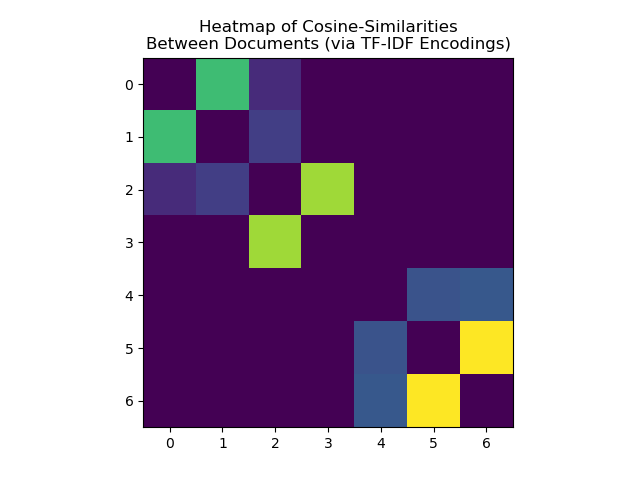

Text(0.5, 1.0, 'Heatmap of Cosine-Similarities\nBetween Documents (via TF-IDF Encodings)')

In [48]:
import matplotlib.pyplot as plt
%matplotlib notebook

from sklearn.metrics.pairwise import cosine_similarity

doc_1 = "Cogworks students learn about artificial intelligence in the form of audio processing, face recognition, and natural language processing."

doc_2 = "Some people think CogWorks is a intense, but these students are simply passionate about artificial intelligence."

doc_3 = "Racecar students are learning about autonomous racing."

doc_4 = "UAV kids are learning about autonomous aerial vehicles!"

doc_5 = "DC and Marvel Universes have long challenged each other in the realm of superheroes."

doc_6 = "Super Heroes produced by DC include Batman, Flash, the Green Lantern and Superman."

doc_7 = "Super Heroes produced by Marvel include Hulk, Thor, Spiderman, and Wolverine."

# 1. Compute the tf-idf vector for each document.
# 2. Use np.vstack to create a shape-(N_doc, N_vocab) array of them
# 3. Compute the shape-(N_doc, N_doc) cosine-similarity matrix
# <COGINST>
word_counts = [to_counter(doc) for doc in [doc_1, doc_2, doc_3, doc_4, doc_5, doc_6, doc_7]]
vocab = to_vocab(word_counts, stop_words=stops)
tfs = np.vstack([to_tf(counter, vocab) for counter in word_counts])
idf = to_idf(vocab, word_counts)
tf_idfs = tfs*idf
cos_sim = cosine_similarity(tf_idfs)
# </COGINST>

# 1. Set the diagonals of the cosine-similarity matrix to 0
# 2. Print the cosine-similarity matrix, rounding to 3 decimal places
# 3. Create a figue & axis with matplotlib and use `ax.imshow(cos_sim)` to
#    plot a "heatmap" of the cosine-similarities between the documents.
#    Use `ax.set_title(...)` to provide a descriptive title.
# <COGINST>

np.einsum("ii->i", cos_sim)[...] = 0
print(np.round(cos_sim, 3))

fig, ax = plt.subplots()

ax.imshow(cos_sim)
ax.set_title("Heatmap of Cosine-Similarities\nBetween Documents (via TF-IDF Encodings)")
# </COGINST>

# Summary
In summary, we seek a method for giving documents numerical descriptors (arrays of numbers) such that they can be summarized and compared quantitatively. We identify a **vocabulary**: an alphabetically sorted list of words that occur in our documents. We typically filter from the vocabulary common **stop-words**, such as "a" and "the", which proliferate our documents yet convey little meaning. We also typically retain only the $k$ most common words across our documents. This will help limit the dimensionality of our descriptors.  

With our vocabulary in-hand, each document, $d$, can be ascribed a **term-frequency** descriptor:

\begin{equation}
f_{t,d} = \frac{c_{t,d}}{\sum_{t' \in vocab}c_{t',d}}
\end{equation}

for each term $t$ in our alphabetically-ordered vocabulary. $c_{t,d}$ is the *count* of term $t$ in that document. This gives us a numerical description of the word-content of the document. 

We can weigh more heavily those terms that help us distinguish between documents, by computing the **inverse document-frequency (IDF)** for each term $t$ in our vocabulary:

\begin{equation}
\log_{10}{\frac{N}{n_{t}}}
\end{equation}

Where $N$ is the number of words in our vocabulary, and $n_{t}$ is the total number of documents in which the term $t$ appears.

Thus the TF-IDF descriptor for a document $d$ is given by an array storing:

\begin{equation}
f_{t,d} \times \log_{10}{\frac{N}{n_{t}}}
\end{equation}

for each $t$ in our vocabulary, in alphabetical order.